In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

print(tf.__version__)

# Build a dataflow graph.
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])
e = tf.matmul(c, d)

# Construct a `Session` to execute the graph.
sess = tf.compat.v1.Session()

# Execute the graph and store the value that `e` represents in `result`.
result = sess.run(e)
print(result)

2.14.0
[[1. 3.]
 [3. 7.]]


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
labels = ['Ulcer', 'Healthy']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=224

for label in labels:
    trainPath = os.path.join('/content/drive/My Drive/DFU Dataset/train',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)

    testPath = os.path.join('/content/drive/My Drive/DFU Dataset/test',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)

X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 110/110 [00:01<00:00, 80.18it/s]


In [5]:
X_train, Y_train = shuffle(X_train,Y_train, random_state=1010)


In [ ]:
#X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=1010)

In [6]:
y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

In [8]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.models import Model, load_model
import pydot
from matplotlib.pyplot import imshow
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D

In [9]:
vgg16 = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in vgg16.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [10]:
x = GlobalAveragePooling2D()(vgg16.output)
x = Dropout(rate=0.4)(x)
x = BatchNormalization()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = BatchNormalization()(x)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=vgg16.inputs, outputs=prediction)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
model.compile(loss='categorical_crossentropy',optimizer = 'adam', metrics= ['accuracy'])

In [12]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("GradCamVgg16.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [13]:
history = model.fit(X_train,Y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Train on 759 samples, validate on 85 samples
Epoch 1/20
759/759 [==============================] - ETA: 0s - loss: 0.3152 - accuracy: 0.8748

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_accuracy improved from -inf to 0.83529, saving model to GradCamVgg16.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


759/759 [==============================] - 21s 28ms/sample - loss: 0.3152 - accuracy: 0.8748 - val_loss: 0.5738 - val_accuracy: 0.8353 - lr: 0.0010
Epoch 2/20
759/759 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.9526
Epoch 2: val_accuracy improved from 0.83529 to 0.95294, saving model to GradCamVgg16.h5
759/759 [==============================] - 4s 5ms/sample - loss: 0.1045 - accuracy: 0.9526 - val_loss: 0.1978 - val_accuracy: 0.9529 - lr: 0.0010
Epoch 3/20
759/759 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9736
Epoch 3: val_accuracy improved from 0.95294 to 0.96471, saving model to GradCamVgg16.h5
759/759 [==============================] - 4s 5ms/sample - loss: 0.0758 - accuracy: 0.9736 - val_loss: 0.1273 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 4/20
759/759 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9776
Epoch 4: val_accuracy improved from 0.96471 to 0.97647, saving model to GradCamVgg16.h5
759/759 

In [14]:
# Saving model and weights
from numpy import loadtxt
from keras.models import load_model
model.save("Vgg16GradCAM.h5")
model = load_model('/content/Vgg16GradCAM.h5')
print("Saved model to disk")

Saved model to disk


In [15]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

Shape of each image : (224, 224, 3)


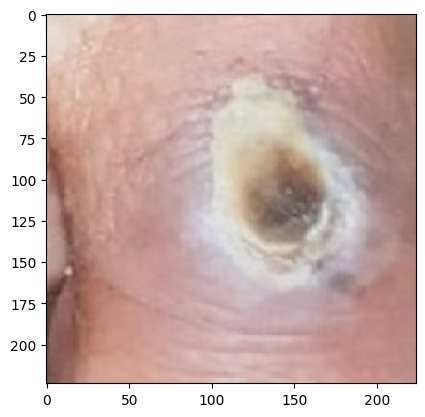

In [16]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Ulcer/image (7).jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)

In [17]:
from keras.activations import softmax, linear
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''

    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()

    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)

    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)

    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear

    return model_without_softmax

def backprop_saliency_map(model, img):

    #calculate grads to input image
    variable = model.input
    loss = model.layers[-1].output
    grads = K.gradients (loss, variable)
    func = K.function([variable], [grads, loss])

    #use the maximum absolute value among channels per pixel
    w, loss_value = func(img)
    saliency_map = np.max(np.absolute(w[0][0]), axis=2)
    return saliency_map

In [18]:
# Backpropagation saliency map
def backpropagation(model, query_img, visualise=True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, query_img)

    if visualise:
        plt.figure(figsize=(10, 20))
        plt.subplot(121)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(np.squeeze(query_img,0))

        plt.subplot(122)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

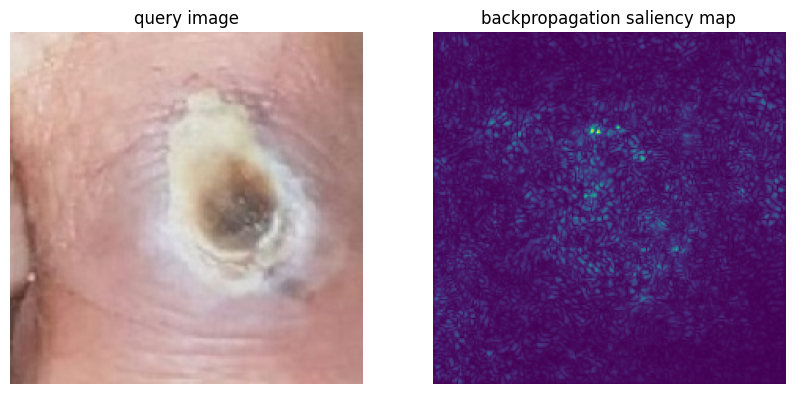

In [19]:
# Backpropagation saliency map
backpropagation(model, np.expand_dims(query_image,0))

In [20]:
# Guided Backpropagation

def build_guided_model():

    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

In [21]:
def guided_backprop_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)

    if visualise:
        plt.figure(figsize=(10, 10))
        plt.subplot(131)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)

        plt.subplot(132)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(133)
        plt.title('Guided backpropagation')
        plt.axis('off')
        plt.imshow(np.squeeze(gb, 0))

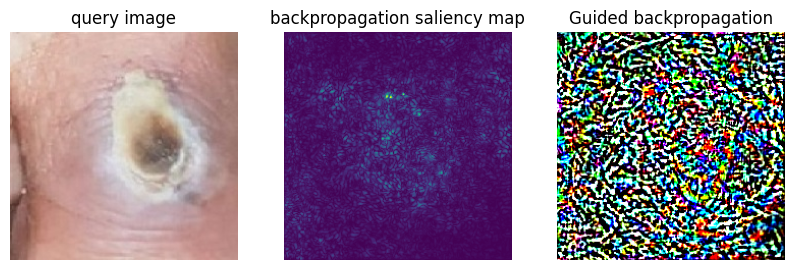

In [23]:
# guided Backpropagation
guided_backprop_saliency_map(model, (query_image), layer_name='block5_conv3')

In [24]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))

    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    cam = cv2.resize(cam, (224,224))

    return cam

In [27]:
def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='block5_conv3' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)

        plt.subplot(142)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)


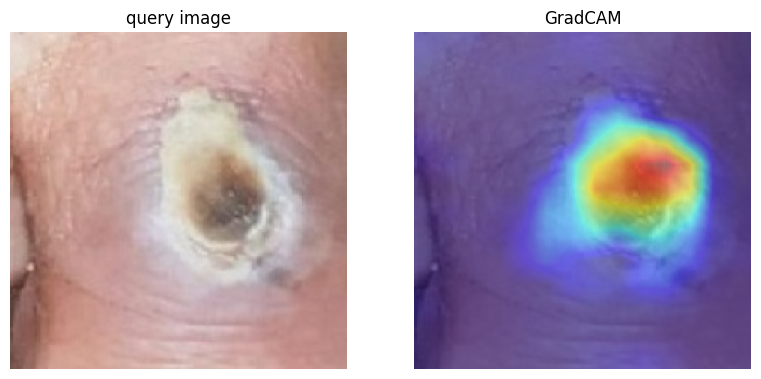

In [28]:
# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'block5_conv3')

Shape of each image : (224, 224, 3)


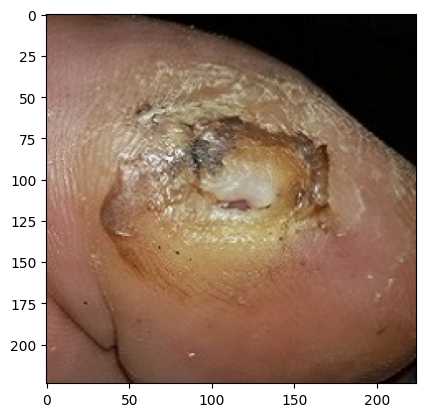

resized_img Dimensions :  (224, 224, 3)


In [29]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Ulcer/image (92).jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)
from keras.activations import softmax, linear
from keras.activations import softmax, linear

In [30]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''

    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()

    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)

    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)

    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear

    return model_without_softmax


In [31]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))

    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    cam = cv2.resize(cam, (224,224))

    return cam

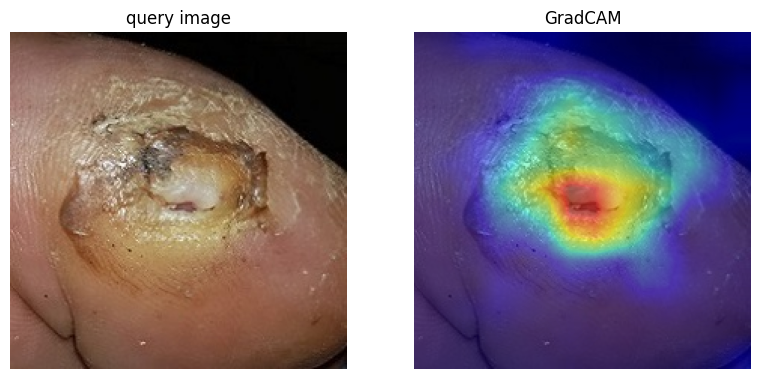

In [32]:
def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='block5_conv3' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)

        plt.subplot(142)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'block5_conv3')

Shape of each image : (224, 224, 3)


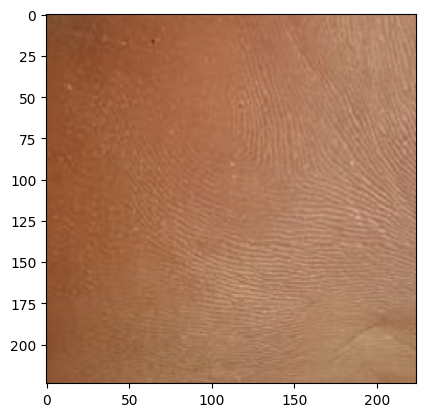

resized_img Dimensions :  (224, 224, 3)


In [51]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Healthy/image (110).jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)
from keras.activations import softmax, linear
from keras.activations import softmax, linear

In [52]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''

    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()

    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)

    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)

    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear

    return model_without_softmax


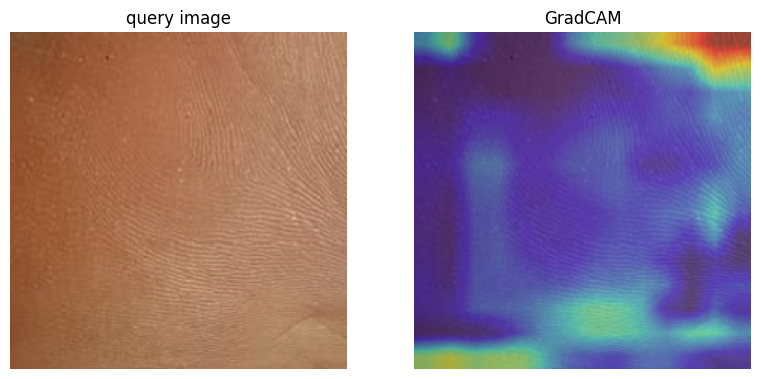

In [53]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))

    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    cam = cv2.resize(cam, (224,224))

    return cam

def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='block5_conv3' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)

        plt.subplot(142)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'block5_conv3')

Shape of each image : (224, 224, 3)


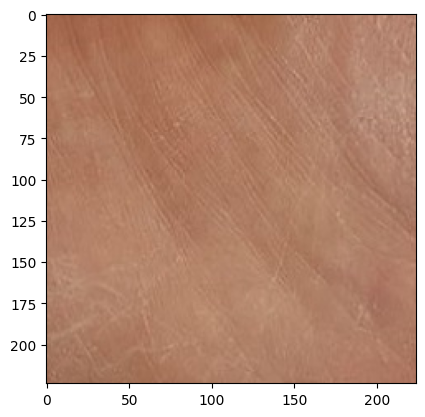

resized_img Dimensions :  (224, 224, 3)


In [36]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Healthy/image (106).jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)
from keras.activations import softmax, linear
from keras.activations import softmax, linear

In [37]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''

    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()

    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)

    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)

    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear

    return model_without_softmax


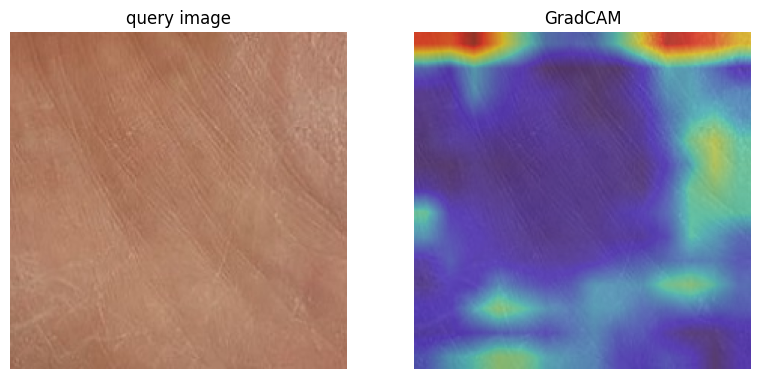

In [38]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))

    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    cam = cv2.resize(cam, (224,224))

    return cam

def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='block5_conv3' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)

        plt.subplot(142)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'block5_conv3')

Shape of each image : (224, 224, 3)


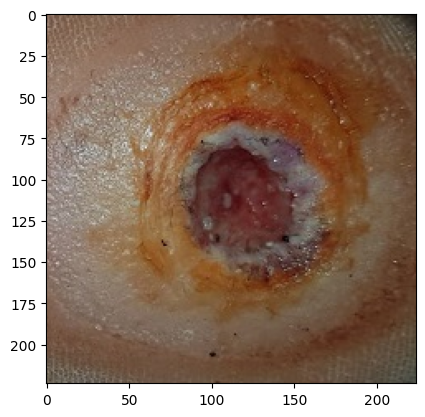

resized_img Dimensions :  (224, 224, 3)


In [39]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Ulcer/image (21).jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)
from keras.activations import softmax, linear
from keras.activations import softmax, linear

In [40]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''

    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()

    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)

    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)

    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear

    return model_without_softmax


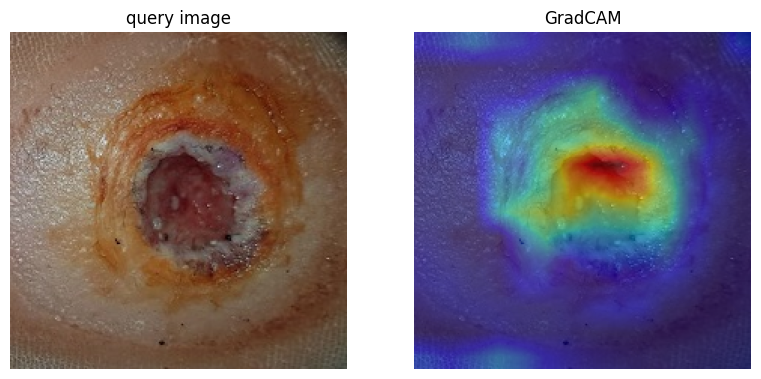

In [41]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))

    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    cam = cv2.resize(cam, (224,224))

    return cam

def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='block5_conv3' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)

        plt.subplot(142)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'block5_conv3')

Shape of each image : (227, 227, 3)


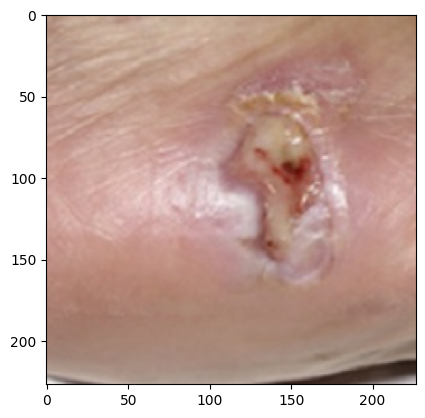

resized_img Dimensions :  (224, 224, 3)


In [42]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Ulcer/image (16).jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)
from keras.activations import softmax, linear
from keras.activations import softmax, linear

In [43]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''

    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()

    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)

    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)

    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear

    return model_without_softmax


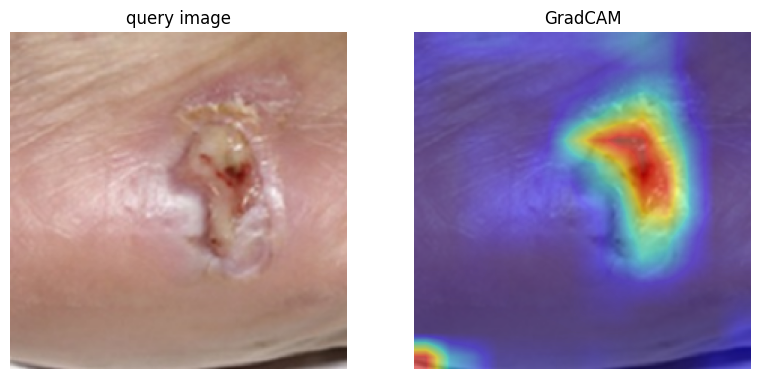

In [44]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))

    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    cam = cv2.resize(cam, (224,224))

    return cam

def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='block5_conv3' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)

        plt.subplot(142)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'block5_conv3')

Shape of each image : (224, 224, 3)


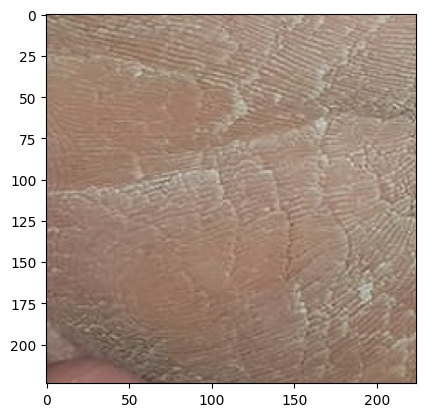

resized_img Dimensions :  (224, 224, 3)


In [45]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Healthy/image (98).jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)
from keras.activations import softmax, linear
from keras.activations import softmax, linear

In [46]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''

    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()

    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)

    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)

    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear

    return model_without_softmax


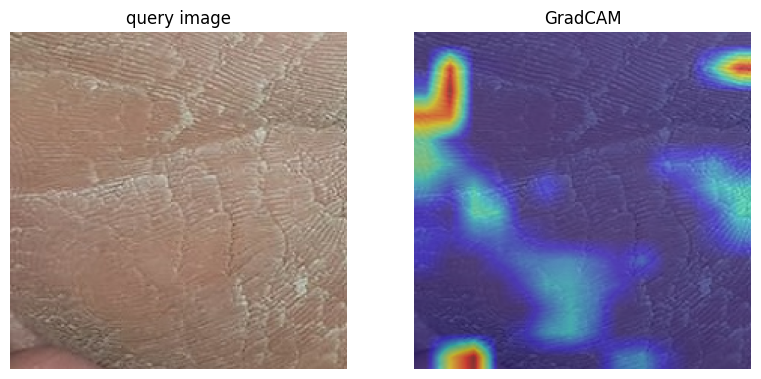

In [47]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))

    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    cam = cv2.resize(cam, (224,224))

    return cam

def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='block5_conv3' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)

        plt.subplot(142)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'block5_conv3')

Shape of each image : (224, 224, 3)


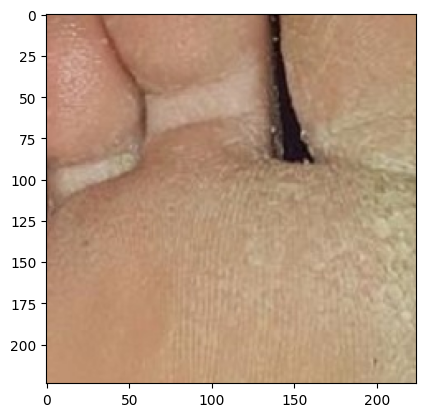

resized_img Dimensions :  (224, 224, 3)


In [54]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/DFU Dataset/test/Healthy/image (90).jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)
from keras.activations import softmax, linear
from keras.activations import softmax, linear

In [55]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''

    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()

    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)

    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)

    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear

    return model_without_softmax


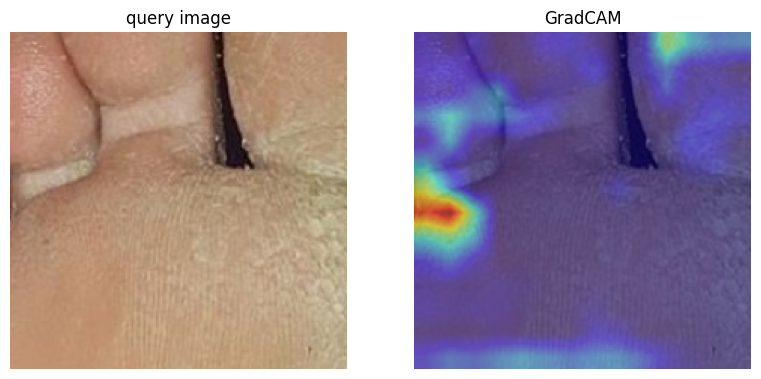

In [57]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))

    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    cam = cv2.resize(cam, (224,224))

    return cam

def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='block5_conv3' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.savefig('pre_con1',dpi=400)
        plt.imshow(query_input)

        plt.subplot(142)
        plt.title('GradCAM')
        plt.axis('off')
        plt.savefig('pre_con',dpi=400)
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'block5_conv3')